<a href="https://colab.research.google.com/github/Happy-ryan/git-practice/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import json
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolsrcValidator


In [13]:
with open("/content/train.json",'r') as f:
 json_data = json.load(f)
print(json.dumps(json_data,indent="\t"))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [464]:
print(json_data.keys())

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])


In [465]:
x_ticks = [i['name'] for i in json_data['categories']]
x_ticks

['General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

### json -> csv 파일 뽑기

In [463]:
df = pd.DataFrame({'image_id':[], "category_id":[],'Xmin':[], 'Ymin':[], 'width':[], 'height':[],
                   'ratio':[], 'area':[]})

for i,info in enumerate(json_data['annotations']):
    df.loc[i] = [
        int(info['image_id']), 
        int(info['category_id']), 
        info['bbox'][0], 
        info['bbox'][1],
        info['bbox'][2],
        info['bbox'][3],
        round(info['bbox'][2]/info['bbox'][3],1),
        info['area'],
    ]
df.head()

,image_id,category_id,Xmin,Ymin,width,height,ratio,area
0,0.0,0.0,197.6,193.7,547.8,469.7,1.2,257301.66
1,1.0,3.0,0.0,407.4,57.6,180.6,0.3,10402.56
2,1.0,7.0,0.0,455.6,144.6,181.6,0.8,26259.36
3,1.0,4.0,722.3,313.4,274.3,251.9,1.1,69096.17
4,1.0,5.0,353.2,671.0,233.7,103.4,2.3,24164.58


In [466]:
for idx, label in enumerate(x_ticks):
    df['category_id'] = df['category_id'].replace({idx: label})
df.head()

,image_id,category_id,Xmin,Ymin,width,height,ratio,area
0,0.0,General trash,197.6,193.7,547.8,469.7,1.2,257301.66
1,1.0,Metal,0.0,407.4,57.6,180.6,0.3,10402.56
2,1.0,Plastic bag,0.0,455.6,144.6,181.6,0.8,26259.36
3,1.0,Glass,722.3,313.4,274.3,251.9,1.1,69096.17
4,1.0,Plastic,353.2,671.0,233.7,103.4,2.3,24164.58


In [539]:
df.sample(100)

,image_id,category_id,Xmin,Ymin,width,height,ratio,area
14680,3102.0,Styrofoam,0.0,95.2,112.1,87.4,1.3,9797.54
16719,3520.0,Plastic,117.1,264.8,364.4,283.1,1.3,103161.64
3675,787.0,General trash,0.0,106.4,483.2,610.5,0.8,294993.60
21873,4594.0,General trash,235.0,241.8,399.2,262.6,1.5,104829.92
13797,2944.0,Paper,168.4,154.8,133.6,467.0,0.3,62391.20
...,...,...,...,...,...,...,...,...
681,138.0,General trash,714.9,698.2,45.0,39.6,1.1,1782.00
15457,3259.0,Paper,154.1,112.0,634.2,461.0,1.4,292366.20
5892,1235.0,Plastic,319.7,336.5,396.9,274.0,1.4,108750.60
1548,300.0,Plastic bag,299.0,329.7,195.7,34.3,5.7,6712.51


### Class별 bbox의 영역 넓이
- Battery의 area가 작은 편으로 확인된다. 추후 inference에서 Battery의 area의 크기가 작아 detection을 잘 하는지 못하는지 확인할 필요가 있다.

In [427]:
df_area = df.groupby("category_id")["area"].max().reset_index()
df_area

,category_id,area
0,Battery,285908.24
1,Clothing,1047961.69
2,General trash,1048064.06
3,Glass,699923.90
4,Metal,745866.82
5,Paper,1048064.06
6,Paper pack,900676.93
7,Plastic,1047961.69
8,Plastic bag,1048371.21
9,Styrofoam,992374.78


In [428]:
# Get max value for each category_id
df_area = df.groupby("category_id")["area"].max().reset_index()

colors = ["darkgray"] * len(df_area)
colors[0] = "tomato" # Battery
colors[8] = "royalblue" # Plastic bag
data = go.Bar(x=df_area["category_id"],
              y=df_area["area"],
               marker = {'color':colors,# 막대 색상 또는 리스트를 이용하여 각 막대 색상 변경가능
                        'line':{'color':'black', 'width':2} # 막대 테두리 설정
                       },
              width=0.5,)
 
# 막대 그래프(Bar Chart, 바 차트)를 포함하는 Figure 생성
fig = go.Figure(data=data,) 

fig.update_layout(title={
    'text': "Area by category_id(Descending)",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Category ID",
    yaxis_title="Area",
    xaxis={"categoryorder":"total descending"}
)

fig.show()

### Class별 개수
- 전체적으로 imbalance한 편이며 Battery의 수는 매우 부족하다. battery는 area도 작은 편이고 데이터의 수도 부족한 편이다.
- 데이터의 숫자가 적은 class의 경우 infernce 결과를 보고 잘 찾지 못하는 경우 조치가 필요할 수도 있다.

In [429]:
df_num = df["category_id"].value_counts().reset_index().rename(columns = {'index': 'category_id', "category_id":"count"})
df_num

,category_id,count
0,Paper,6352
1,Plastic bag,5178
2,General trash,3966
3,Plastic,2943
4,Styrofoam,1263
5,Glass,982
6,Metal,936
7,Paper pack,897
8,Clothing,468
9,Battery,159


In [462]:
df_num = df["category_id"].value_counts().reset_index().rename(columns = {'index': 'category_id', "category_id":"count"})
df_num

colors = ["darkgray"] * 10
colors[9] = "tomato" # Battery
colors[0] = "royalblue" # Plastic bag
data = go.Bar(x=df_num["category_id"],
              y=df_num["count"],
              text= [f"{(val * 100 /df_num['count'].sum()):.1f}%\n{val}" for val in df_num["count"]],
              textposition='auto', # 텍스트 위치 자동 조정
              textangle=0, # 0도로 텍스트 각도 설정
              marker = {'color':colors,
                        'line':{'color':'black', 'width':2}
                       },
              width=0.5,)
 
fig = go.Figure(data=data,) 

fig.update_layout(title={
    'text': "Count by category_id(Descending)",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Category ID",
    yaxis_title="Count",
    xaxis={"categoryorder":"total descending"}
)

fig.show()

### 각 Class 간의 상관관계


In [431]:
# 모든 이미지에 대한 상관관계
class_counts = df["category_id"].value_counts()
# 클래스 간의 상관 행렬 생성
correlation_matrix = df.groupby('image_id')['category_id'].value_counts().unstack(fill_value=0)
correlation_matrix = correlation_matrix.corr()
correlation_matrix

category_id,Battery,Clothing,General trash,Glass,Metal,Paper,Paper pack,Plastic,Plastic bag,Styrofoam
category_id,,,,,,,,,,
Battery,1.000000,-0.000843,-0.026508,-0.009936,-0.011374,-0.026007,-0.015272,-0.016721,-0.030928,-0.013472
Clothing,-0.000843,1.000000,-0.010906,-0.015238,0.009861,-0.011464,-0.022074,0.015576,-0.030655,-0.020178
General trash,-0.026508,-0.010906,1.000000,0.048851,0.011742,0.191082,0.134688,0.177106,0.190799,0.157882
Glass,-0.009936,-0.015238,0.048851,1.000000,0.028642,-0.020542,0.007446,0.037719,-0.026547,-0.012647
Metal,-0.011374,0.009861,0.011742,0.028642,1.000000,-0.004682,-0.007763,0.045943,-0.006183,-0.012134
Paper,-0.026007,-0.011464,0.191082,-0.020542,-0.004682,1.000000,0.082790,0.117806,0.259844,0.058093
Paper pack,-0.015272,-0.022074,0.134688,0.007446,-0.007763,0.082790,1.000000,0.081845,0.051302,-0.008700
Plastic,-0.016721,0.015576,0.177106,0.037719,0.045943,0.117806,0.081845,1.000000,0.228465,0.057775
Plastic bag,-0.030928,-0.030655,0.190799,-0.026547,-0.006183,0.259844,0.051302,0.228465,1.000000,0.140297


In [432]:
data = go.Heatmap(z=correlation_matrix.values, x=class_counts.index, y=class_counts.index, autocolorscale=True)
annotations = []
for i, row in enumerate(correlation_matrix.values):
    for j, val in enumerate(row):
        annotations.append(
            dict(
                text=f"{val:.2f}",
                x=class_counts.index[j],
                y=class_counts.index[i],
                xanchor='center',
                yanchor='middle',
                showarrow=False,
                font=dict(color='white' if val > 0.5 else ('blue' if val > 0.2 else 'black'),)
            )
        )

fig = go.Figure(data=data)
fig.update_layout(
    title={
    'text': "Class Correlation In All Images(Heatmap)",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title='Category ID',
    yaxis_title='Category ID',
    annotations=annotations
)
fig.show()

### 한 Image 안에 bbox 의 수
- 한 이미지 안에 최대 71개의 box가 존재하는데 클래스는 10개에 불과하다. 한 이미지 내에서 bbox의 숫자가 과도하게 많을 때 잘 판단하는지 확인할 필요가 있다.
- 판단했을 때 유의미한 결과를 얻지 못할 경우 그 데이터를 지우는 것도 고려해야한다.  

In [433]:
df_box = df.groupby("image_id")["category_id"].count().reset_index().rename(columns={"image_id":"id", "category_id": "box_count"})
df_box

,id,box_count
0,0.0,1
1,1.0,8
2,2.0,1
3,3.0,2
4,4.0,6
...,...,...
4878,4878.0,1
4879,4879.0,4
4880,4880.0,1
4881,4881.0,4


In [727]:
# box count by image_id
df_box = df.groupby("image_id")["category_id"].count().reset_index().rename(columns={"image_id":"id", "category_id": "box_count"})

# set color for box_count > 원하는 값
color = ['rgb(255, 0, 0)' if cnt >= 50 else 'rgb(0, 0, 255)' for cnt in df_box['box_count']]

# create scatter plot
data = go.Scatter(x=df_box["id"],
                  y=df_box["box_count"],
                  mode='markers',
                  marker=dict(color=color))

# update layout
fig = go.Figure(data=data) 

fig.update_layout(title={
    'text': "Box Count by Image_id(Scatter)",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Image_id",
    yaxis_title="box_count",
    xaxis={"categoryorder":"total descending"}
)

fig.show()

In [435]:
df_box = df.groupby("image_id")["category_id"].count().reset_index().rename(columns={"image_id":"id", "category_id": "box_count"})

data = go.Histogram(x=df_box["box_count"],
               marker = {'color': "deepskyblue",
                        'line':{'color':'black', 'width':1}
                       },
                opacity=0.7)

fig = go.Figure(data=data) 

fig.update_layout(title={
    'text': "Box Count Per Image(BarChart)",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Box_count",
    yaxis_title="Frequency",
    xaxis={"categoryorder":"total descending"}
)

fig.show()

In [451]:
df_box = df.groupby("image_id")["category_id"].count().reset_index().rename(columns={"image_id":"id", "category_id": "box_count"})
df_box = df_box["box_count"].value_counts().reset_index().rename(columns={"index":"box_count", "box_count": "count"})
df_box.describe()

,box_count,count
count,47.000000,47.000000
mean,25.170213,103.893617
std,15.906410,309.625105
min,1.000000,1.000000
25%,12.500000,3.000000
50%,24.000000,16.000000
75%,36.000000,57.500000
max,71.000000,1980.000000


In [452]:
colors = ["darkgray"] * len(df_box)
colors[0] = "tomato" 
colors[45] = "royalblue"

data = go.Bar(x=df_box["box_count"],
              y=df_box["count"],
              text=df_box["count"],
              textangle=0, # 0도로 텍스트 각도 설정
              textposition='auto', # 텍스트 위치 자동 조정
              marker = {'color':colors,
                        'line':{'color':'black', 'width':2}
                       },
              width=0.5,)
 
fig = go.Figure(data=data,) 

fig.update_layout(title={
    'text': "Box Count Per Image(BarChart)",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Box_count",
    yaxis_title="Frequency",
    xaxis={"categoryorder":"total descending"}
)

fig.show()

# Box ratio

In [533]:
df_ratio = df.groupby(["category_id", "ratio"])["image_id"].count().reset_index(name="count")
df_general_trash = df_ratio[df_ratio["category_id"] == "General trash"]
df_general_trash

,category_id,ratio,count
81,General trash,0.1,41
82,General trash,0.2,91
83,General trash,0.3,110
84,General trash,0.4,176
85,General trash,0.5,189
...,...,...,...
176,General trash,16.5,1
177,General trash,17.1,1
178,General trash,17.7,1
179,General trash,18.9,1


In [669]:
data = go.Box(x=df["category_id"],
              y=df["ratio"],
              pointpos=0)

fig = go.Figure(data=data)

fig.update_layout(title={
    'text': "Box ratio by class(Box)",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Class(Category_id)",
    yaxis_title="Ratio",
    boxmode='group',
    boxgroupgap=0.4,
    boxgap=0.3)

fig.show()

### bbox 표시하기

In [629]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [630]:
# 이미지에 Bbox 그리기
# confidence와 class 추가

def visualize_bbox(img, bbox, color=(0, 255, 0), thickness=2):
    """
    img: numpy.ndarray, shape (H, W, C)
        이미지 데이터
    bbox: list
        bbox 정보 [x_min, y_min, x_max, y_max]
    color: tuple
        bbox 색상 (B, G, R)
    thickness: int
        bbox 두께
    """
    # bbox 정보 추출
    x_min, y_min, x_max, y_max = bbox

    # bbox 그리기
    img_bbox = cv2.rectangle(
        img, (x_min, y_min), (x_max, y_max), color, thickness)

    return img_bbox

In [655]:
def visualize_bbox(img, bbox, color=(0, 255, 0), thickness=2):
    """
    img: numpy.ndarray, shape (H, W, C)
        이미지 데이터
    bbox: list
        bbox 정보 [x_min, y_min, x_max, y_max]
    color: tuple
        bbox 색상 (B, G, R)
    thickness: int
        bbox 두께
    """
    # bbox 정보 추출
    x_min, y_min, x_max, y_max = bbox

    # bbox 그리기
    img_bbox = cv2.rectangle(
        img, (x_min, y_min), (x_max, y_max), color, thickness)

    # bbox 위에 text 쓰기
    cv2.putText(img_bbox, 'Object', (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

    return img_bbox 

In [733]:
# out_num : 한 이미지 내에서 박스의 개수
def check_outlier(out_num:int):
    outliers = defaultdict()
    for idx, cnt in enumerate(df_box['box_count']):
        if cnt >= out_num:
            outliers[f"{idx:04}"] = cnt
    return outliers
print(check_outlier(50))

defaultdict(None, {'0946': 55, '4047': 52, '4197': 71})


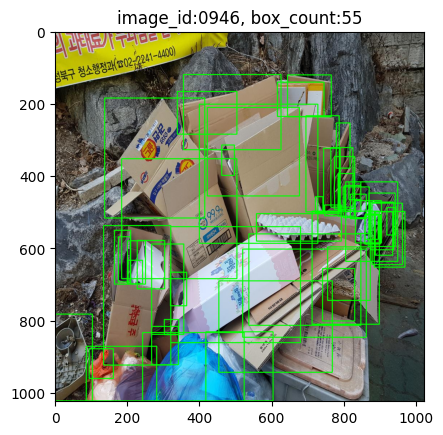

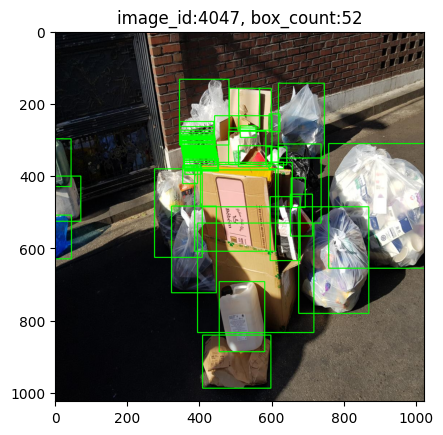

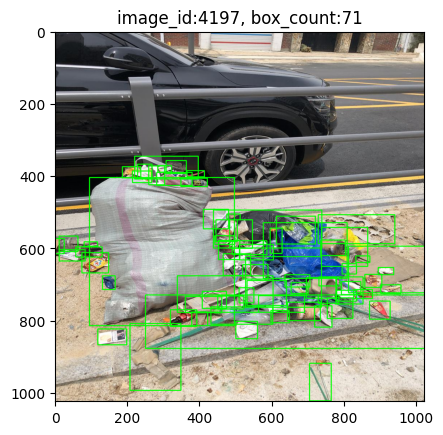

In [734]:
# 특정 image_id의 bbox 생성
def draw_bbox(outlier:int, value:int):
    image_dir = f'/content/drive/MyDrive/train/{outlier}.jpg' 
    bbox = df[df['image_id'] == int(outlier)] 

    image = cv2.imread(image_dir) 
    for i in range(len(bbox)):
        x_min, y_min, w, h = bbox.iloc[i]['Xmin'], bbox.iloc[i]['Ymin'], bbox.iloc[i]['width'], bbox.iloc[i]['height'] # bbox 좌표값 추출
        x_max, y_max = x_min + w, y_min + h
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"image_id:{outlier}, box_count:{value}")
    plt.show()

for id, value in check_outlier(50).items():
    draw_bbox(id, value)

In [683]:
bbox_data = df.groupby("category_id")[["Xmin", "Ymin", "width" ,"height"]].value_counts().reset_index()
bbox_data

,category_id,Xmin,Ymin,width,height,0
0,Battery,23.7,323.6,395.2,366.2,1
1,Battery,287.5,361.9,288.9,129.8,1
2,Battery,364.3,433.6,297.1,122.3,1
3,Battery,362.2,567.9,323.6,124.6,1
4,Battery,349.1,277.8,100.9,274.8,1
...,...,...,...,...,...,...
23106,Styrofoam,166.8,674.2,818.1,45.3,1
23107,Styrofoam,166.1,81.6,462.0,415.8,1
23108,Styrofoam,165.8,596.7,261.3,206.2,1
23109,Styrofoam,164.9,178.0,602.8,431.7,1


In [725]:
# 카테고리별 bbox 좌표 정보 추출
bbox_data = df.groupby("category_id")[["Xmin", "Ymin", "width", "height"]].value_counts().reset_index()

# subplot 생성
fig = make_subplots(rows=2, cols=2, subplot_titles=("Xmin", "Ymin", "Width", "Height"))

# 각 좌표 정보에 대한 box plot 추가
for idx, coord in enumerate(["Xmin", "Ymin", "width", "height"]):
    row = idx // 2 + 1
    col = idx % 2 + 1
    fig.add_trace(go.Box(x=bbox_data["category_id"], y=bbox_data[coord], name=coord), row=row, col=col)


fig.update_layout(title={
    'text': "Xmin, Ymin, width, height",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    yaxis_title="Ratio",
    boxmode='group',
    boxgroupgap=0.4,
    boxgap=0.3)

fig.show()